In [6]:
"""
Question 1:
- some of the conditions for convergence in simulated annealing are that moves must be reversible and any feasible states are reachable from any other states in finite moves.
we have [0,1] x [0,1] so S \in R^2
We can randomize a move through picking a random number between (minimum, maximum)^2. As we have no tabu list unlike tabu search ,we do not need to adhere to discrete uniform space. So for each move we try we randomize via (random(minimum_x, maximum_x),(minimum_y, maximum_y)).
This way we can reverse any moves that were made because those move has potentially to be randomized again and that any feasible states are reachable in this continuous space.
"""
print()

In [462]:
# Question 3 - read .dat file
# question 2 is below, q2 and q3 usage are together.
def read_qap_instance(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Read the size of the problem instance
    l1 = lines[0].strip().split()
    problem_size, best_solution_value = int(l1[0]), None if len(l1) == 1 else tuple(map(int, l1))

    # Read the distance matrix
    distance_matrix = np.zeros((problem_size, problem_size))
    for i in range(2, problem_size + 2):
        row = list(map(int, lines[i].strip().split()))
        distance_matrix[i - 2] = row

    # Read the flow matrix
    flow_matrix = np.zeros((problem_size, problem_size))
    for i in range(problem_size + 3, 2 * problem_size + 3):
        row = list(map(int, lines[i].strip().split()))
        flow_matrix[i - problem_size - 3] = row

    return problem_size, distance_matrix, flow_matrix


In [38]:
# pseudo random number generator from Ivan.
import math
import time


class TausWorth:

    def __init__(self, tausi1=None, tausi2=None):
        "initialize the tausworth random number generator"

        if tausi1 is not None and tausi2 is not None:
            self.tausi1 = tausi1
            self.tausi2 = tausi2
        else:

            frac, integer = math.modf(time.time())
            self.tausi1 = int(integer)
            self.tausi2 = int(frac * 1000)

        self.invvalue = 1.0 / 2147483647.0

        print("\nTausWorth RNG initialized with %d %d" % (self.tausi1, self.tausi2))

    def get(self):
        "return a pseudo random number 0 < x < 1"

        self.tausi1 = ((self.tausi1 << 12) ^ ((((self.tausi1 << 13) ^ self.tausi1) & 2147483647) >> 19)) & 2147483647
        self.tausi2 = ((self.tausi2 << 17) ^ ((((self.tausi2 << 2) ^ self.tausi2) & 536870911) >> 12)) & 536870911

        return (((self.tausi2 << 2) ^ self.tausi1) * self.invvalue)


In [454]:
"""
Solve QAP with SA
Note that TSP is special case of QAP
2-opt should theoretically works - swapping objects mean 2-opt since objects correspond to order in which cities are visited (according to the book or slides (cant remember)).
so since tabu search we have already been using 2-opt for implementation.`
Note: skeleton of classes are generated by ChatGPT because I suck at naming things as can be seen in the tabu search notebook.
However, in a way, most of this code is copied pasted from Tabu search - evaluation, moves, etc.
Only the actual SA algorithm is needed to be implemented.

We did not go with Tausworth and just use Python's because adding additional option for various probability does not make sense.
Prof. Jan is probably the one who gave out this assignment. I'm not sure why he gave us the Tausworth's pseudo random number generator when Python's will work just fine - but for the sake of
"""
import numpy as np
import random
import math


def generate_moves(indices):
    """
    generate all possible index swap
    :param indices:
    :return:
    """
    moves = []
    for i in range(len(indices) - 1):
        for j in range(i + 1, len(indices)):
            if i == j:
                continue
            moves.append((i, j))
    return moves


class SimulatedAnnealingQAP:
    def __init__(self,
                 flow_matrix,
                 distance_matrix,
                 cooling_factor: float = 0.90,
                 stagnant_termination: int = 3,
                 initial_moves: int = 100,
                 initial_acceptance_probability: float = 0.5):
        self.flow_matrix = flow_matrix
        self.distance_matrix = distance_matrix
        self.problem_size = len(self.flow_matrix)  # aka degree of freedom
        self.cooling_factor = cooling_factor
        # initialize initial solutions
        self.solution = np.arange(self.problem_size)
        np.random.shuffle(self.solution)
        # all possible moves for any solution in QAP problem
        self.possible_moves = generate_moves(np.arange(self.problem_size))
        self.fitness = self.evaluate_solution(self.solution)
        self.stagnant_termination = stagnant_termination
        self.initial_moves = initial_moves
        self.initial_acceptance_probability = initial_acceptance_probability
        self.temperature = self.determine_initial_temperature()
        # let's also save best solution
        self.best_solution = self.solution
        self.best_fitness = self.fitness

    def determine_initial_temperature(self):
        """
        Run and collect initial_moves * problem_size worse moves to get its overage of energy differences
        and then based on equation 4.1 (refer to textbook)- which we apply natural log on to both the probability and e - we can reverse find temperature needed to cross energy barrier with given probability
        Note that if it's the solution is moved to a fitter solution, the move still happens but energy is not collected.
        :return:
        """
        solution = np.copy(self.solution)
        cost_differences = []
        fitness = self.fitness
        while len(cost_differences) < self.initial_moves * self.problem_size:
            move = self.get_next_move()
            neighbor = self.get_neighbor(solution, move)
            cost_difference = self.evaluate_neighbor(solution, neighbor, move, fitness)
            if cost_difference > 0:
                cost_differences.append(cost_difference)
                continue
            solution = neighbor
            fitness = fitness + cost_difference
        if len(cost_differences) == 0:  # we are in good area
            return 0.2
        avg_cost_difference = sum(cost_differences) / len(cost_differences)
        # by default math.log is natural log
        t0 = -1. * avg_cost_difference / math.log(self.initial_acceptance_probability)
        return max([0.5, t0])  # give max of 0.5 or t0 whicever is more

    @staticmethod
    def is_move_accepted(accepted_probability):
        return random.random() < accepted_probability

    @staticmethod
    def get_acceptance_probability(cost_difference, temperature):
        # TODO: Implement acceptance probability function
        return min(1, np.exp(-1. * (cost_difference / temperature)))

    def get_next_move(self):
        return self.possible_moves[np.random.randint(0, len(self.possible_moves))]

    def get_neighbor(self, solution, move):
        new_solution = np.copy(solution)
        new_solution[move[0]], new_solution[move[1]] = new_solution[move[1]], new_solution[move[0]]
        return new_solution

    def evaluate_neighbor(self, solution, neighbor, move, fitness):
        """
        generate fitness difference
        :param solution:
        :param neighbor:
        :param move:
        :param fitness: fitness of solution
        :return: difference of neighbor fitness to current fitness
        """
        nfitness = fitness
        # remove old fitness via new solution
        for m in move:
            for i in range(len(solution)):
                nfitness -= self.flow_matrix[solution[m]][solution[i]] * self.distance_matrix[m][i]
                nfitness -= self.flow_matrix[solution[i]][solution[m]] * self.distance_matrix[i][m]

        # add new fitness via neighbor
        for m in move:
            for i in range(len(neighbor)):
                nfitness += self.flow_matrix[neighbor[m]][neighbor[i]] * self.distance_matrix[m][i]
                nfitness += self.flow_matrix[neighbor[i]][neighbor[m]] * self.distance_matrix[i][m]

        return nfitness - fitness

    def evaluate_solution(self, solution):
        fitness = 0
        for i in range(len(solution)):
            for j in range(len(solution)):
                fitness += self.flow_matrix[solution[i]][solution[j]] * self.distance_matrix[i][j]
        return fitness

    def solve(self):
        # TODO: Implement the Simulated Annealing algorithm
        terminal_i = 0
        while terminal_i < self.stagnant_termination:
            current_stage_fitness = self.fitness
            accepted_moves = 0
            for i in range(self.problem_size * 100):
                next_move = self.get_next_move()
                neighbor = self.get_neighbor(self.solution, next_move)
                cost_difference = self.evaluate_neighbor(self.solution, neighbor, next_move, self.fitness)
                accepted_probability = self.get_acceptance_probability(cost_difference, self.temperature)
                if self.is_move_accepted(accepted_probability):
                    accepted_moves += 1
                    self.solution = neighbor
                    self.fitness = cost_difference + self.fitness
                if self.fitness < self.best_fitness:
                    self.best_solution = self.solution
                    self.best_fitness = self.fitness
                if accepted_moves == 12 * self.problem_size:
                    break
            self.temperature = self.cooling_factor * self.temperature

            if np.isclose(current_stage_fitness, self.fitness):
                terminal_i += 1
            else:
                terminal_i = 0


In [425]:
problem_size, optimal, F, D = read_qap_instance('nug5.dat')


In [426]:
print(F)
print(D)

[[0. 1. 1. 2. 3.]
 [1. 0. 2. 1. 2.]
 [1. 2. 0. 1. 2.]
 [2. 1. 1. 0. 1.]
 [3. 2. 2. 1. 0.]]
[[0. 5. 2. 4. 1.]
 [5. 0. 3. 0. 2.]
 [2. 3. 0. 0. 0.]
 [4. 0. 0. 0. 5.]
 [1. 2. 0. 5. 0.]]


In [448]:
saqap = SimulatedAnnealingQAP(
    F,
    D
)
# why does a temperature of 7.2 fail to explore?
# problematic solutions [3 4 1 2 0] 60.0
print(saqap.temperature)

15.425295377184797


In [449]:
saqap.solve()

In [450]:
print(saqap.solution, saqap.fitness, saqap.best_solution, saqap.best_fitness)

[2 3 4 0 1] 50.0 [1 3 4 0 2] 50.0


In [451]:
"""
we should do a final vs best fitness landscape - i just want to check
if we our stuffs is doing the right thing.
This is extension - i just want to be cool
"""
import matplotlib.pyplot as plt

def base_list_to_integer(base_list):
    base = len(base_list)
    value = 0
    for digit in base_list:
        value = value * base + digit
    return value


def integer_to_base_list(number, base):
    # generated by chatgpt because I can't be bothered to elegantly write this code.
    base_list = [0] * base
    for i in range(base - 1, -1, -1):
        base_list[i] = number % base
        number //= base
    return base_list


class QAPFitnessLandscape:
    def __init__(self, flow_matrix, distance_matrix):
        self.problem_size = len(flow_matrix)
        self.flow_matrix = flow_matrix
        self.distance_matrix = distance_matrix

    def evaluate_solution(self, solution):
        fitness = 0
        for i in range(len(solution)):
            for j in range(len(solution)):
                fitness += self.flow_matrix[solution[i]][solution[j]] * self.distance_matrix[i][j]
        return fitness

    def plot_with_solutions(self, solutions, color='r'):
        self.plot()
        x = [base_list_to_integer(solution) for solution in solutions]
        y = [self.evaluate_solution(solution) for solution in solutions]
        plt.plot(x,y,'o',color=color)

    def plot(self):
        def is_valid_solution(solution):
            return len(solution) == len(set(solution))
        # search space to the power search space
        x = np.arange(self.problem_size ** self.problem_size)
        solutions = [integer_to_base_list(i, self.problem_size) for i in x]
        # filter out solutions that contain duplicate number
        is_valids = list(map(is_valid_solution, solutions))
        x = x[is_valids]
        solutions = list(filter(is_valid_solution, solutions))
        y = [self.evaluate_solution(solution) for solution in solutions]
        plt.plot(x, y)

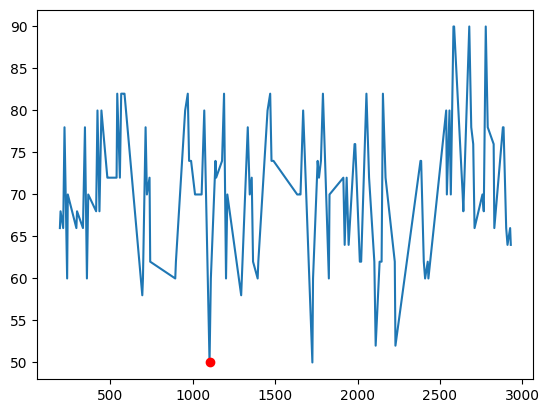

In [452]:
QAPFitnessLandscape(F, D).plot_with_solutions([saqap.best_solution])

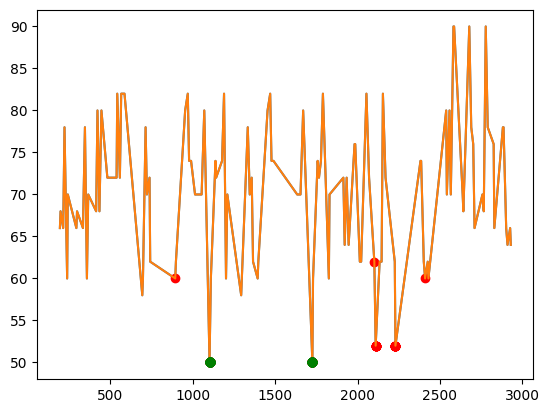

In [453]:
# compare 100 instances of final solutions and best solutions
problem_size, F, D = read_qap_instance('nug5.dat')
final_solutions = []
best_solutions = []
for i in range(100):
    saqap = SimulatedAnnealingQAP(
        F,
        D
    )
    saqap.solve()
    final_solutions.append(saqap.solution)
    best_solutions.append(saqap.best_solution)
qapls = QAPFitnessLandscape(F, D)
qapls.plot_with_solutions(final_solutions, color='r')
qapls.plot_with_solutions(best_solutions, color='g')


In [419]:
-1. * (10) / math.log(0.5)

14.426950408889635

In [459]:
# compare 100 instances of final solutions and best solutions
problem_size, F, D = read_qap_instance('nug12.dat')
final_solutions = []
final_fits = []
best_solutions = []
best_fits = []
for i in range(50):
    saqap = SimulatedAnnealingQAP(
        F,
        D
    )
    saqap.solve()
    final_solutions.append(saqap.solution)
    final_fits.append(saqap.fitness)
    best_solutions.append(saqap.best_solution)
    best_fits.append(saqap.best_fitness)

In [460]:
print(sum(final_fits)/len(final_fits))
print(sum(best_fits)/len(best_fits))

587.04
580.8


In [461]:
best_fits

[586.0,
 586.0,
 578.0,
 586.0,
 586.0,
 578.0,
 578.0,
 578.0,
 582.0,
 578.0,
 586.0,
 578.0,
 578.0,
 578.0,
 578.0,
 578.0,
 586.0,
 578.0,
 586.0,
 578.0,
 578.0,
 578.0,
 578.0,
 578.0,
 586.0,
 582.0,
 578.0,
 578.0,
 578.0,
 586.0,
 578.0,
 586.0,
 578.0,
 586.0,
 578.0,
 578.0,
 578.0,
 578.0,
 578.0,
 578.0,
 586.0,
 578.0,
 586.0,
 582.0,
 586.0,
 582.0,
 582.0,
 586.0,
 578.0,
 578.0]

In [ ]:
print(sum(final_fits)/len(final_fits))
print(sum(best_fits)/len(best_fits))

In [463]:
# compare 100 instances of final solutions and best solutions
problem_size, F, D = read_qap_instance('nug24.dat')
final_solutions = []
final_fits = []
best_solutions = []
best_fits = []
for i in range(50):
    saqap = SimulatedAnnealingQAP(
        F,
        D
    )
    saqap.solve()
    final_solutions.append(saqap.solution)
    final_fits.append(saqap.fitness)
    best_solutions.append(saqap.best_solution)
    best_fits.append(saqap.best_fitness)

In [464]:
print(min(best_fits))

3488.0


In [465]:
best_fits

[3506.0,
 3518.0,
 3520.0,
 3488.0,
 3548.0,
 3552.0,
 3524.0,
 3520.0,
 3520.0,
 3518.0,
 3490.0,
 3540.0,
 3488.0,
 3490.0,
 3546.0,
 3488.0,
 3548.0,
 3520.0,
 3552.0,
 3516.0,
 3494.0,
 3488.0,
 3510.0,
 3554.0,
 3530.0,
 3488.0,
 3586.0,
 3554.0,
 3500.0,
 3488.0,
 3526.0,
 3506.0,
 3488.0,
 3488.0,
 3488.0,
 3528.0,
 3524.0,
 3530.0,
 3564.0,
 3528.0,
 3516.0,
 3520.0,
 3516.0,
 3514.0,
 3490.0,
 3510.0,
 3518.0,
 3506.0,
 3520.0,
 3488.0]